             date    price   returns  absreturn  survival
8680   1990-08-25  3164.00 -0.543779   0.543779  0.021277
9480   1987-11-07  2644.67 -0.358663   0.358663  0.042553
9160   1988-12-20  5214.12 -0.273754   0.273754  0.063830
13260  1974-10-28   231.22 -0.244317   0.244317  0.085106
8880   1989-12-11  8176.00 -0.241276   0.241276  0.106383
Taiwan stock index N 777 MS 0.16
             date    price   returns  absreturn  survival
2560   2008-10-21   955.05 -0.218448   0.218448  0.012987
7840   1987-11-12   248.52 -0.181839   0.181839  0.025974
14240  1962-05-28    55.50 -0.161690   0.161690  0.038961
4340   2001-09-26  1007.04 -0.145972   0.145972  0.051948
4080   2002-10-08   798.55 -0.130185   0.130185  0.064935
S&P500 stock index N 867 MS 0.24
Gaussian with same σ as TAIEX N 778 MS 0.08


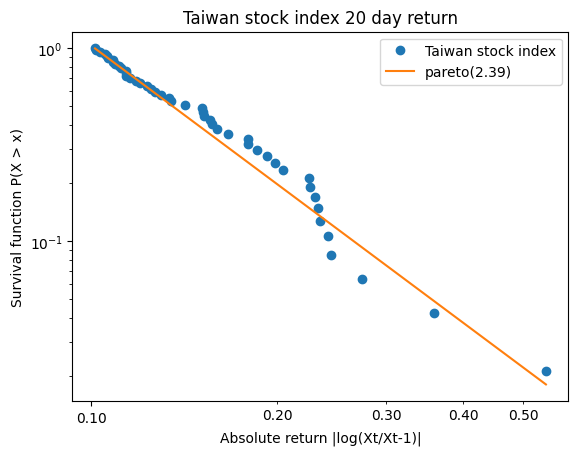

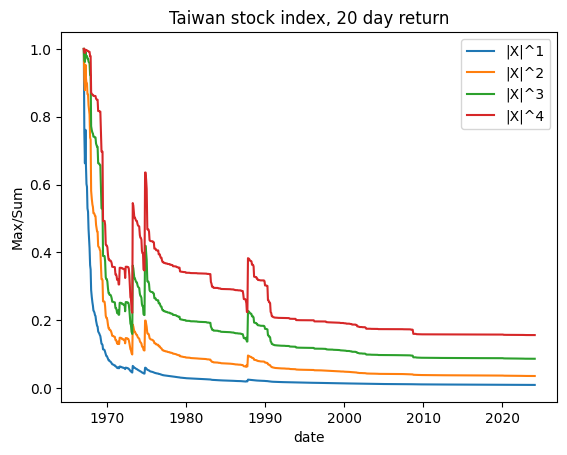

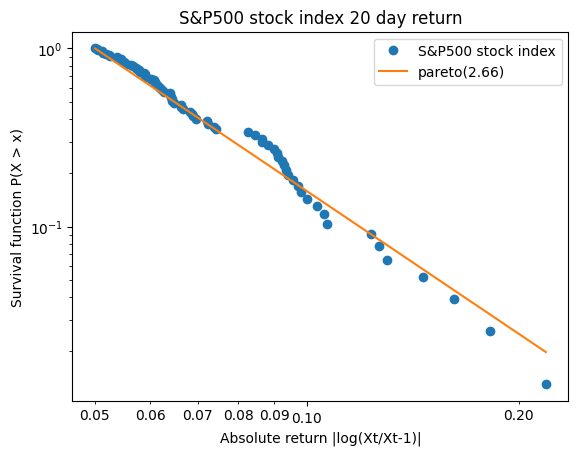

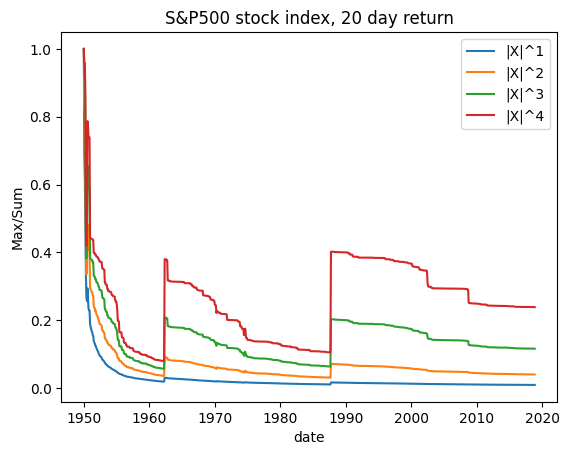

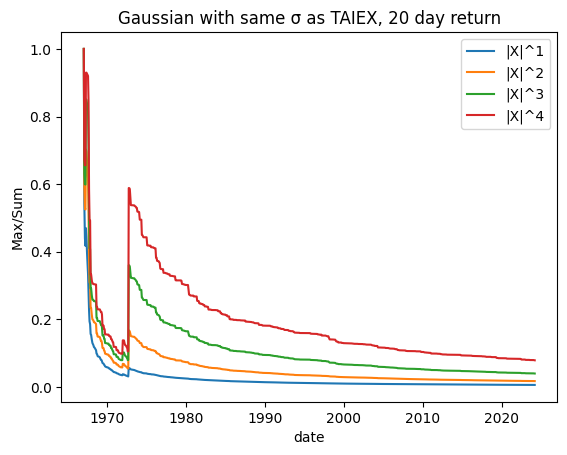

In [1]:
import numpy as np
import pandas
import scipy
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt


class Analysis:
    def __init__(self):
        self.name = ""
        self.fpath = ""

        self.lag = 1
        self.tailCutoff = 0.001


def analyzePareto(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})
    
    # df["returns"] = df.price / df.price.shift(-analysis.lag)-1
    # df.drop(df.tail(analysis.lag).index,inplace=True)
    df = df.iloc[::analysis.lag, :]
    df["returns"] = df.price / df.price.shift(-1)-1
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)

    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))
    df = df[df.returns < 0]
    df = df[(df.absreturn > analysis.lag*analysis.tailCutoff)]
    if len(df) == 0:
        return
    
    # Maximum likelihood method. 
    xm = np.min(df.absreturn)
    alpha = len(df)/np.sum(np.log(df.absreturn/xm))

    # Scipy method.
    scipyPareto = scipy.stats.pareto.fit(df.absreturn, scale=analysis.lag*0.02)
    scipyAlpha = scipyPareto[0]

    df = df.sort_values(by='absreturn', ascending=False)
    df["survival"] = 1-(df.absreturn.rank()-1) / len(df)
    fitted = np.power(xm/df.absreturn, alpha)
    
    print(df.head(5))
    fig, ax = plt.subplots(1, 1)
    ax.plot(df.absreturn, df.survival, "o", label=analysis.name)
    ax.plot(df.absreturn, fitted, label=("pareto(%.2f)"%(alpha)))
    ax.legend()
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '%.2f' % x))
    ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '%.2f' % x))
    ax.set_title("%s %d day return" % (analysis.name, analysis.lag))
    ax.set_xlabel("Absolute return |log(Xt/Xt-1)|")
    ax.set_ylabel("Survival function P(X > x)")
    fig.savefig("loglog_%s"%analysis.name)


def analyzeMSp(df, p):
    df["Xp%d" % p] = np.power(df.absreturn, p)

    df["msMax%d" % p] = df["Xp%d" % p].cummax()
    if False:
        k = 10
        for i in range(len(df)):
            subset = df.iloc[:i+1]
            vs = subset["Xp%d" % p].to_numpy().copy()
    
            vs = np.sort(vs)
            largest = vs[max(0, len(vs)-k):]
            mx = np.sum(largest)
    
            df.iloc[i, df.columns.get_loc("msMax%d" % p)] = mx
            
    
    df["msSum%d" % p] = df["Xp%d" % p].cumsum()
    df["ms%d" % p] = df["msMax%d" % p] / df["msSum%d" % p]


def plotMS(analysis, df):
    fig, ax = plt.subplots(1, 1)
    for p in [1, 2, 3, 4]:
        analyzeMSp(df, p)
        x = matplotlib.dates.date2num(df.date)
        y = df["ms%d" % p].to_numpy()
        x = x[0:]
        y = y[0:]
        ax.plot_date(x, y, fmt="-", label=("|X|^%d" % p))
    ax.legend()
    ax.set_title("%s, %d day return" % (analysis.name, analysis.lag))
    ax.set_xlabel("date")
    ax.set_ylabel("Max/Sum")
    # fig.savefig("ms_%s"%analysis.name)
    print("%s N %d MS %.2f" % (analysis.name, len(df), df.iloc[len(df)-1]["ms4"]))


def analyzeMS(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})
    df = df.sort_values(by='date', ascending=True)
    df = df.iloc[::analysis.lag, :]
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)
    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))

    plotMS(analysis, df)
    #df.to_csv("qqq.csv")


def analyze(analysis):
    analyzePareto(analysis)
    analyzeMS(analysis)


# Plot a MS-plot for a normal distribution corresponding to TAIEX.
def ms_taiex_gaussian():
    analysis = Analysis()
    analysis.name = "Gaussian with same σ as TAIEX"
    analysis.lag = 20
    
    # Compute daily standard deviation
    df = pandas.read_csv("taiex.csv", dtype={'price': np.float64})
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)
    mean = np.mean(df.returns)
    std = np.std(df.returns)
    
    # Simulate a normal distribution using the computed standard deviation.
    df = pandas.read_csv("taiex.csv", dtype={'price': np.float64})
    df = df.sort_values(by='date', ascending=True)
    df = df.iloc[::analysis.lag, :]
    mean *= analysis.lag
    std *= np.sqrt(analysis.lag)
    df["absreturn"] = np.abs(np.random.normal(loc=mean, scale=std, size=len(df)))
    plotMS(analysis, df)


for lag in [20]:
    for tailCutoff in [0.005]:
        analysis = Analysis()
        analysis.name = "Taiwan stock index"
        analysis.fpath = "taiex.csv"
        analysis.lag = lag
        analysis.tailCutoff = tailCutoff
        analyze(analysis)
        
        analysis.name = "S&P500 stock index"
        analysis.fpath = "sp500.csv"
        analysis.tailCutoff = 0.0025
        analyze(analysis)
ms_taiex_gaussian()